In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, math, datetime
from pprint import pformat
from graphviz import Digraph
from itertools import combinations
from scipy.interpolate import interp1d
import hmms
import os
import math

In [2]:
# Configuration parameters
N_nodes = 81
# Observation matrix params
prob_emission_equals_hidden = 0.99
prob_emission_not_equals_hidden = 1 - prob_emission_equals_hidden
prob_emission_not_equals_hidden

0.010000000000000009

In [3]:
# Load training QTC_C sequences (generated in simulation) - Robot is 1st object in these and lab seqs
ot_sim_seqs = np.load("ot_sim_seqs.npy", allow_pickle=True)
pb_sim_seqs = np.load("pb_sim_seqs.npy", allow_pickle=True)
pc_sim_seqs = np.load("pc_sim_seqs.npy", allow_pickle=True)

In [4]:
# Load validation QTC_C sequences (recorded in lab)
ot_lab_seqs = []
pb_lab_seqs = []
pc_lab_seqs = []
u_lab_seqs = []

with open("lab_qtc_seqs.pickle", "rb") as f:
    lab_seqs = pickle.load(f)
lab_seqs

for key in lab_seqs.keys():
    class_code = key.split("_")[0]
    if class_code == "ot":
        ot_lab_seqs.append(lab_seqs[key])
    elif class_code == "pb":
        pb_lab_seqs.append(lab_seqs[key])
    elif class_code == "pc":
        pc_lab_seqs.append(lab_seqs[key])
    else:
        u_lab_seqs.append(lab_seqs[key])
        
print(len(ot_lab_seqs))
print(len(pb_lab_seqs))
print(len(pc_lab_seqs))
print(len(u_lab_seqs))

20
10
10
25


In [5]:
# Create list of QTC_C states so that indices can be used as integer state IDs compatible with HMM library
QTC_symbols = []
for i in range(0,4):
    QTC_symbols.append("-")
    QTC_symbols.append("0")
    QTC_symbols.append("+")
print("QTC symbols:", QTC_symbols[:3])
QTC_C_states = list(combinations(QTC_symbols, 4))
QTC_C_states = [state[0] + state[1] + state[2] + state[3] for state in QTC_C_states]
QTC_C_states = list(np.unique(QTC_C_states))
print("QTC_C states:\n", QTC_C_states)
print(len(QTC_C_states), "states total")

QTC symbols: ['-', '0', '+']
QTC_C states:
 ['++++', '+++-', '+++0', '++-+', '++--', '++-0', '++0+', '++0-', '++00', '+-++', '+-+-', '+-+0', '+--+', '+---', '+--0', '+-0+', '+-0-', '+-00', '+0++', '+0+-', '+0+0', '+0-+', '+0--', '+0-0', '+00+', '+00-', '+000', '-+++', '-++-', '-++0', '-+-+', '-+--', '-+-0', '-+0+', '-+0-', '-+00', '--++', '--+-', '--+0', '---+', '----', '---0', '--0+', '--0-', '--00', '-0++', '-0+-', '-0+0', '-0-+', '-0--', '-0-0', '-00+', '-00-', '-000', '0+++', '0++-', '0++0', '0+-+', '0+--', '0+-0', '0+0+', '0+0-', '0+00', '0-++', '0-+-', '0-+0', '0--+', '0---', '0--0', '0-0+', '0-0-', '0-00', '00++', '00+-', '00+0', '00-+', '00--', '00-0', '000+', '000-', '0000']
81 states total


In [6]:
def QTC_C_to_num(QTC_C):
    return QTC_C_states.index(QTC_C)


def QTC_C_seq_to_num_seq(QTC_C_seq):
    num_seq = []
    for QTC_C in QTC_C_seq:
        num_seq.append(QTC_C_to_num(QTC_C))

    return num_seq


def num_to_QTC_C(num):
    return QTC_C_states[num]


def num_seq_to_QTC_C_seq(num_seq):
    QTC_C_seq = []
    for num in num_seq:
        QTC_C_seq.append(num_to_QTC_C(num))

    return QTC_C_seq


print(QTC_C_to_num("++--"))
print(num_to_QTC_C(8))
print(num_seq_to_QTC_C_seq([0, 1, 2, 3]))
print(QTC_C_seq_to_num_seq(num_seq_to_QTC_C_seq([0, 1, 2, 3])))

4
++00
['++++', '+++-', '+++0', '++-+']
[0, 1, 2, 3]


In [7]:
# Defining a uniform transition matrix of N_nodes states
uniform_trans_mat = np.zeros((N_nodes, N_nodes))
uniform_trans_mat = np.array([[1/N_nodes for trans in row] for row in uniform_trans_mat])
print("\n", uniform_trans_mat)
row_sums = []
for row in uniform_trans_mat:
    row_sums.append(np.sum(row))
print(np.mean(row_sums))


 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0


In [8]:
def draw_transition_matrix(trans_matrix, filename, min_trans_prob):
    # draw its transition matrix
    dot = Digraph(comment='HMM model')
    col, row = trans_matrix.shape
    for i in range(0, col):
        for j in range(0, row):
#             print(i, j, trans_matrix[i, j])
            if trans_matrix[i, j] >= min_trans_prob:
#                 print(i, j, "is a high probability transition")
                dot.edge(num_to_QTC_C(i), num_to_QTC_C(j), label='{:2.2f}'.format(trans_matrix[i, j]))

    dot.render(filename, view=True)

## Creating pass-by HMM

In [9]:
# pass_by_seqs = [
#     ["--00", "--00", "--+0", "00++", "++++", "++00"],
#     ["--00", "--00", "--+0", "--++", "++++", "++00"],
#     ["--00", "--00", "---0", "00--", "++--", "++00"],
#     ["--00", "--00", "---0", "----", "++--", "++00"],
#     ["--00", "--00", "--+0", "00++", "++++", "++++"],
#     ["--00", "--00", "--+0", "--++", "++++", "++++"],
#     ["--00", "--00", "---0", "00--", "++--", "++--"],
#     ["--00", "--00", "---0", "----", "++--", "++--"],
#     ["--00", "--0+", "--++", "00++", "++++", "++++"],
#     ["--00", "--0+", "--++", "--++", "++++", "++++"],
#     ["--00", "--0-", "----", "----", "++--", "++--"],
#     ["--00", "--0-", "----", "00--", "++--", "++--"],
#     ["-000", "-0+0", "-0+0", "+0+0", "+0+0", "+000"],
#     ["-000", "-0+0", "00+0", "+0+0", "+0+0", "+000"],
#     ["-000", "-0+0", "00+0", "+0+0", "+0+0", "+0+0"],
#     ["-000", "-0+0", "-0+0", "+0+0", "+0+0", "+0+0"],
#     ["-000", "-0-0", "-0-0", "+0-0", "+0-0", "+000"],
#     ["-000", "-0-0", "00-0", "+0-0", "+0-0", "+000"],
#     ["-000", "-0-0", "00-0", "+0-0", "+0-0", "+0-0"],
#     ["-000", "-0-0", "-0-0", "+0-0", "+0-0", "+0-0"]
# ]

pass_by_seqs = pb_sim_seqs

In [10]:
pass_by_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_seqs]
print(pass_by_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_seqs]

[[71, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 70, 70, 70, 70, 70, 70, 71, 71, 70, 70, 70, 70, 70, 70, 70, 70, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 67, 67, 76, 76, 58, 58, 58, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 23, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26], [71, 71, 71, 71, 71, 69, 69, 69, 69, 69, 69, 69, 71, 71, 71, 69, 69, 69, 69, 69, 69, 69, 71, 69, 69, 69, 69, 69, 42, 42, 44, 42, 42, 42, 42, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 63, 72, 72, 72, 72, 72, 54, 0, 0, 0, 0, 

[['0-00',
  '0-0-',
  '0-00',
  '0-00',
  '0-00',
  '0-00',
  '0-00',
  '0-00',
  '0-00',
  '0-00',
  '0-00',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-00',
  '0-00',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '0-0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '--0-',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '----',
  '0---',
  '0---',
  '00--',
  '00--',
  '0+--',
  '0+--',
  '0+--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '++--',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',
  '+0-0',


In [11]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += 1

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118

In [12]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_seqs:
    Pi[seq[0]] += 1

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pbHMM = hmms.DtHMM(A, B, Pi)

# Check pbHMM params
A, B, Pi = pbHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.55223881 0.00497512 0.03482587 ... 0.00497512 0.00497512 0.00497512]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.0483871  0.00806452 0.28225806 ... 0.00806452 0.00806452 0.00806452]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.90123457e-01 1.23456790e-04 1.23456790e-04 ... 1.23456790e-04
  1.23456790e-04 1.23456790e-04]
 [1.23456790e-04 9.90123457e-01 1.23456790e-04 ... 1.23456790e-04
  1.23456790e-04 1.23456790e-04]
 [1.23456790e-04 1.23456790e-04 9.90123457e-01 ... 1.23456790e-04
  1.23456790e-04 1.23456790e-04]
 ...
 [1.23456790e-04 1.23456790e-04 1.23456790e-04 ... 9.90123457e-01
  1.23456790e-04 1.23456790e-04]
 [1.23456790e-04 1.23456790e-04 1.23456790e-04 ... 1.23456790e-04
  9.90123457e-01 1.23456790e-04]
 [1.23456790e-04 1.23456790e-04 1.23456790e-

In [13]:
draw_transition_matrix(A,"QTC_C_Pass-By_Handcrafted_Egs_Transitions", 0.013)

Pass-by HMM:


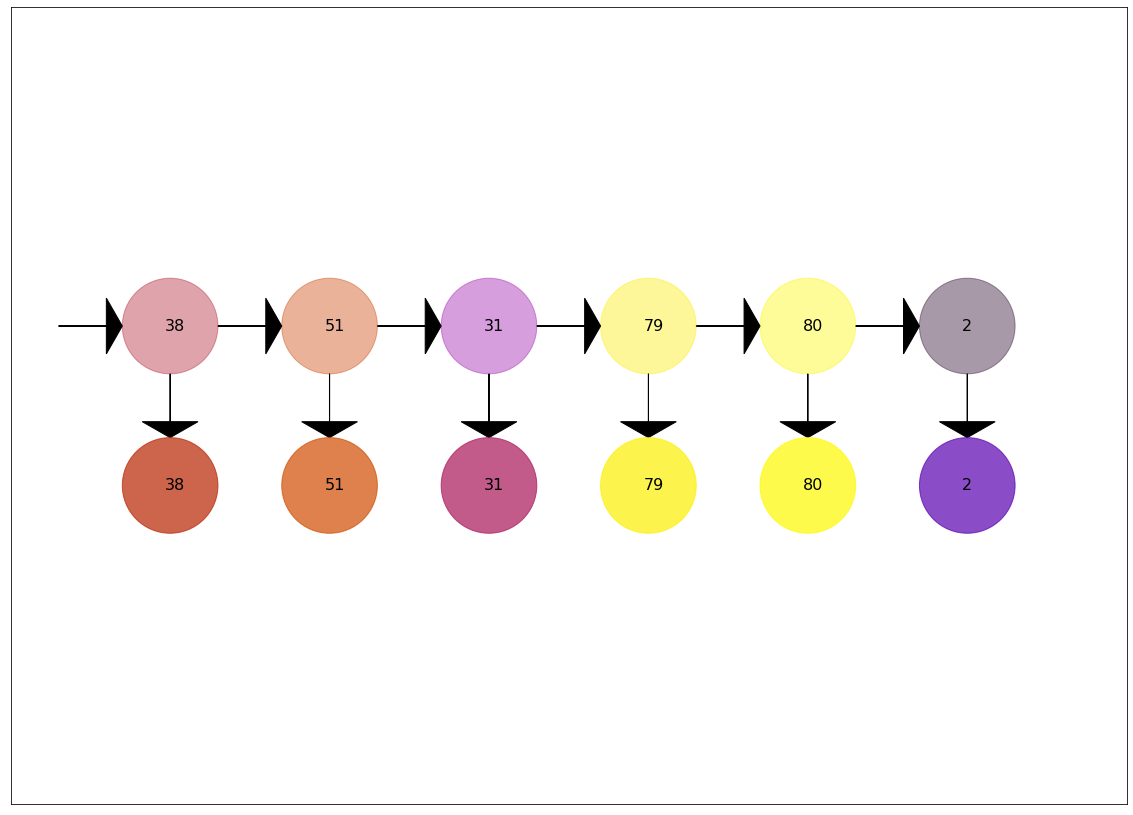

['--+0', '-00+', '-+--', '000-', '0000', '+++0']


In [14]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pbHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating overtake HMM

In [15]:
# overtake_seqs = [
#     ["-+00", "-++0", "-++-", "-++-", "+-+-", "+-+-"],
#     ["-+00", "-+-0", "-+-+", "-+-+", "++-+", "+--+"]
# ]

overtake_seqs = ot_sim_seqs

In [16]:
overtake_seqs = [list(map(QTC_C_to_num, seq)) for seq in overtake_seqs]
print(overtake_seqs)
[list(map(num_to_QTC_C, seq)) for seq in overtake_seqs]

[[79, 79, 79, 79, 79, 79, 79, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 34, 34, 34, 34, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 74], [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 78, 78, 60, 60, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

[['000-',
  '000-',
  '000-',
  '000-',
  '000-',
  '000-',
  '000-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '0+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-++-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+00',
  '-+00',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+0-',
  '-+00',
  '-+00',
  '-+00',
  '-+00',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',
  '-000',


In [17]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in overtake_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += 1

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120

In [18]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in overtake_seqs:
    Pi[seq[0]] += 1

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
otHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = otHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.04444444 0.07777778 0.01111111]
1.0
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234

In [19]:
A.min()

0.0016891891891891895

In [20]:
draw_transition_matrix(A, "QTC_C_Overtake_Handcrafted_Egs_Transitions", 0.0124)

Overtake HMM:


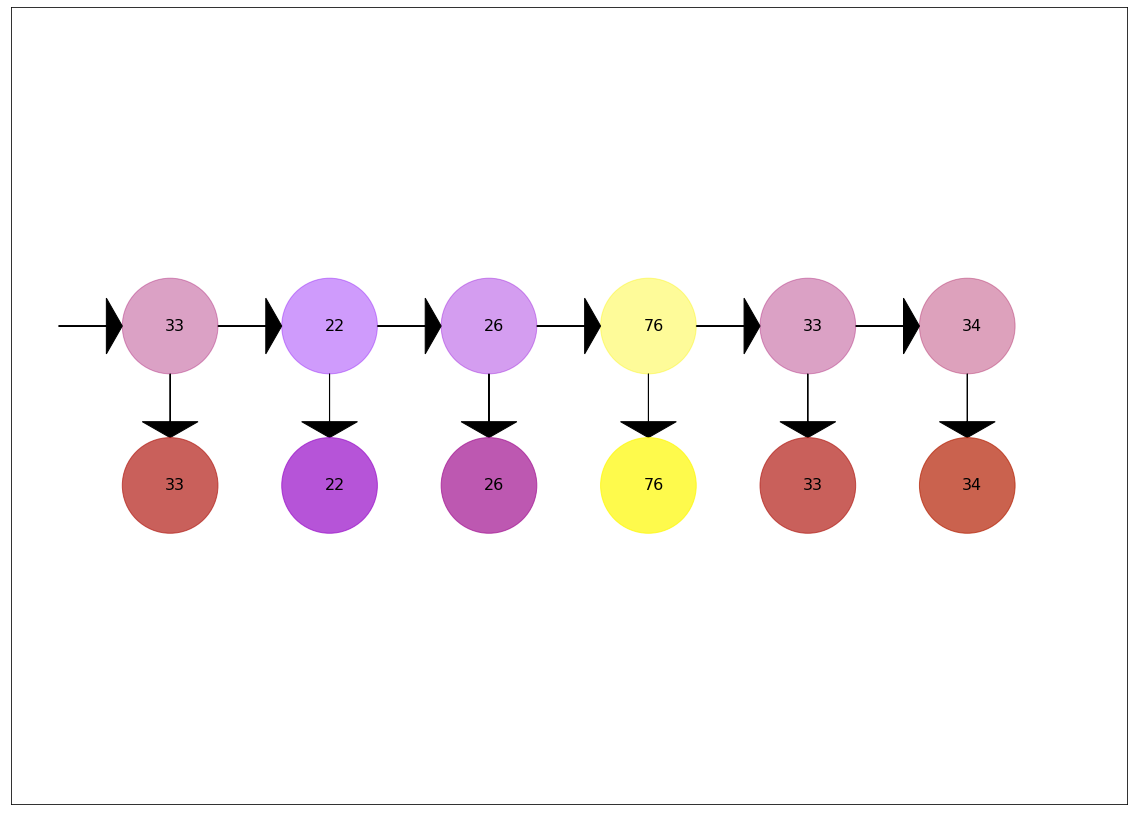

['-+0+', '+0--', '+000', '00--', '-+0+', '-+0-']


In [21]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = otHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Overtake HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating path-crossing HMM

In [22]:
pc_seqs = pc_sim_seqs

In [23]:
pc_seqs = [list(map(QTC_C_to_num, seq)) for seq in pc_seqs]
print(pc_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pc_seqs]

[[69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 42, 42, 42, 42, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 48, 48, 48, 51, 51, 51, 51, 51, 51, 51, 42, 42, 42, 42, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 33, 51, 51, 51, 51, 33, 27, 27, 27, 45, 27, 27, 27, 27, 27, 27, 27, 27, 29, 29, 29, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 54, 56, 56, 56, 56, 56, 56, 56, 56, 55, 56, 55, 55, 55, 55, 55, 55, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 55, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 61, 62, 62, 62, 62, 61, 62, 62, 62, 61, 61, 62, 61, 62, 61, 61, 62, 62, 62, 62, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62], [69, 69, 69, 69, 69, 69, 69, 69, 69

[['0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '0-0+',
  '--0+',
  '--0+',
  '--0+',
  '--0+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '---+',
  '-0-+',
  '-0-+',
  '-0-+',
  '-00+',
  '-00+',
  '-00+',
  '-00+',
  '-00+',
  '-00+',
  '-00+',
  '--0+',
  '--0+',
  '--0+',
  '--0+',
  '-00+',
  '-00+',
  '-00+',
  '-00+',
  '-00+',
  '-00+',


In [24]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pc_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += 1

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
3

In [25]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pc_seqs:
    Pi[seq[0]] += 1

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pcHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pcHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.06521739 0.07608696 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957]
1.0
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.00588

In [26]:
A.min()

0.0035842293906810044

In [27]:
draw_transition_matrix(A, "QTC_C_Path_Crossing_Sim_Egs_Transitions", 0.0124)

Path-crossing HMM:


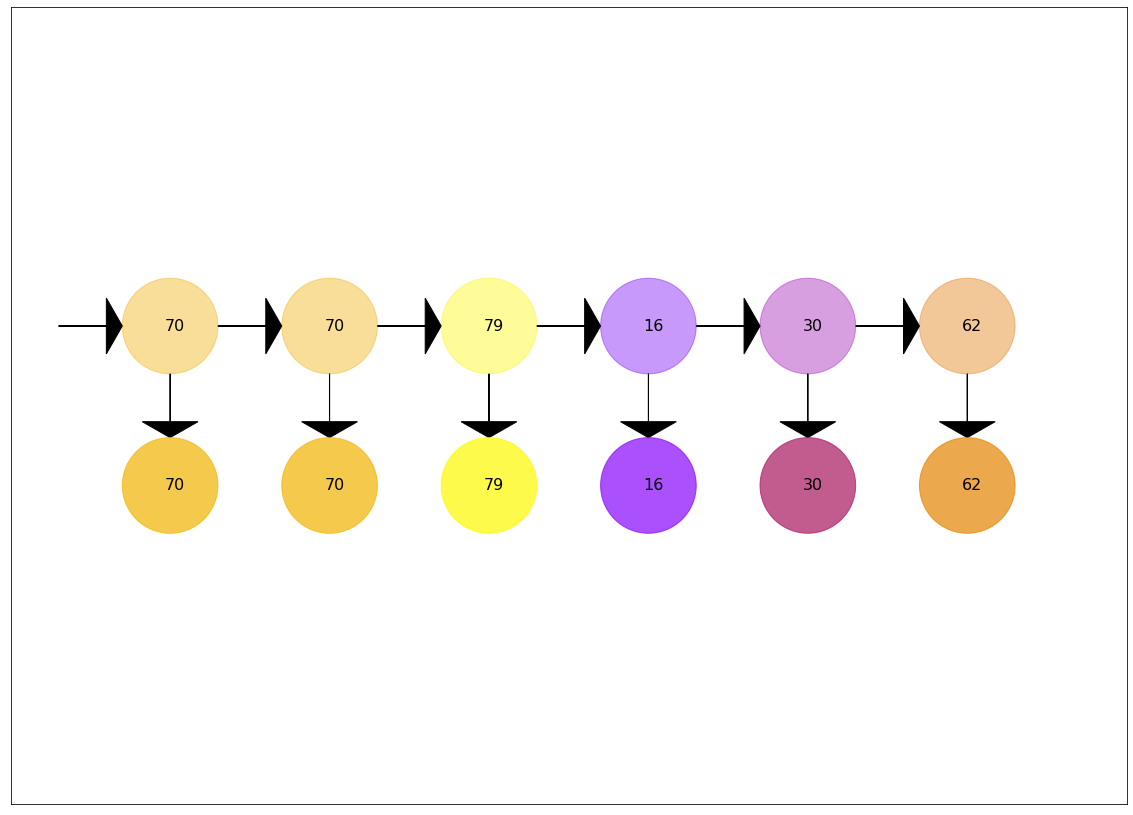

['0-0-', '0-0-', '000-', '+-0-', '-+-+', '0+00']


In [28]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pcHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating uniform HMM

In [29]:
# Create HMM using uniform parameters as a baseline to compare against pass-by
uniform_HMM = hmms.DtHMM(uniform_trans_mat, B, (np.ones((1, N_nodes)) * (1 / N_nodes))[0])

# Check uniform_HMM params
A_uniform, B_uniform, Pi_uniform = uniform_HMM.params
print("A:\n", A_uniform)
for row in A_uniform:
    print(row.sum())
print("B:\n", B_uniform)
for row in B_uniform:
    print(row.sum())
print("Pi:\n", Pi_uniform)
print(Pi_uniform.sum())

A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0

uniform HMM:


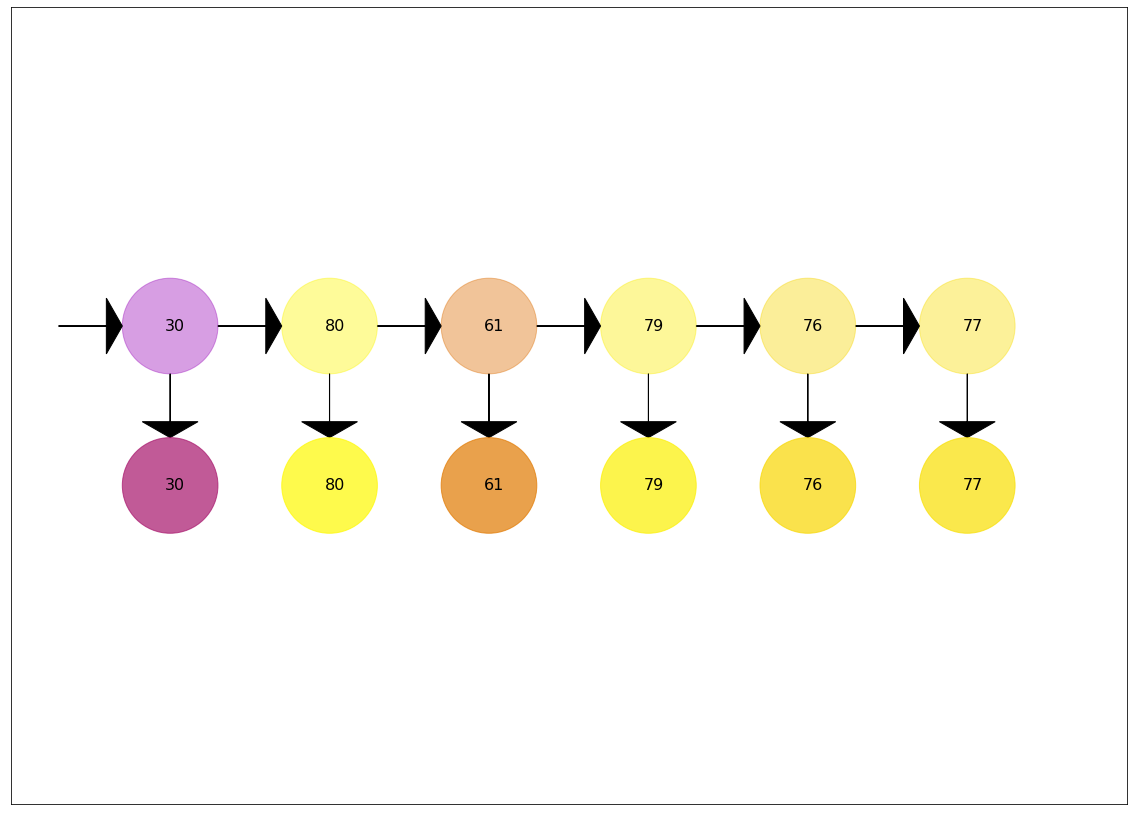

['-+-+', '0000', '0+0-', '000-', '00--', '00-0']


In [30]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = uniform_HMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("uniform HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Classifying HRI situation of generic QTC<sub>C</sub> sequences generated by uniform HMM

In [31]:
# Generate dataset of both hidden states and emissions sequences from uniform HMM
s_seqs, e_seqs = uniform_HMM.generate_data((len(pass_by_seqs), len(pass_by_seqs[0])))
e_seqs

print(s_seqs)

ll_pb = pbHMM.data_estimate(e_seqs)
print(ll_pb)
prob_pb = np.exp(ll_pb)

print("The probability of the dataset being generated by the pass-by model is:", \
      prob_pb, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the uniform model is:", \
      prob_uniform, ".")

ll_ot = otHMM.data_estimate(e_seqs)
print(ll_ot)
prob_ot = np.exp(ll_ot)

print("The probability of the dataset being generated by the overtake model is:", \
      prob_ot, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by", "overtake", "path-crossing", "unknown"]
class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[32 21 80 ... 50 58 63]
 [40 20  9 ... 39 47 70]
 [36 38 45 ... 35 42 71]
 ...
 [73 41 50 ... 77 46 70]
 [53 25 55 ... 13 71 62]
 [31 10 79 ...  1 20 10]]
-8387.685363091983
The probability of the dataset being generated by the pass-by model is: 0.0 .
-8129.7309361439975
The probability of the dataset being generated by the uniform model is: 0.0 .
-8343.662617029235
The probability of the dataset being generated by the overtake model is: 0.0 .
-8507.141967472702
The probability of the dataset being generated by the path-crossing model is: 0.0 .
Classified as unknown


## Classifying HRI situation of example pass-by QTC<sub>C</sub> sequences

In [32]:
pass_by_seqs = [np.array(seq) for seq in pass_by_seqs]

In [33]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_seqs)

print(s_seqs)

ll_pb = pbHMM.data_estimate(e_seqs)
print(ll_pb)
prob_pb = np.exp(ll_pb)

print("The probability of the dataset being generated by the pass-by model is:", \
      prob_pb, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the uniform model is:", \
      prob_uniform, ".")

ll_ot = otHMM.data_estimate(e_seqs)
print(ll_ot)
prob_ot = np.exp(ll_ot)

print("The probability of the dataset being generated by the overtake model is:", \
      prob_ot, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by", "overtake", "path-crossing", "unknown"]
class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[32 21 80 ... 50 58 63]
 [40 20  9 ... 39 47 70]
 [36 38 45 ... 35 42 71]
 ...
 [73 41 50 ... 77 46 70]
 [53 25 55 ... 13 71 62]
 [31 10 79 ...  1 20 10]]
-1742.828408678819
The probability of the dataset being generated by the pass-by model is: 0.0 .
-8340.664495568275
The probability of the dataset being generated by the uniform model is: 0.0 .
-8343.650944837202
The probability of the dataset being generated by the overtake model is: 0.0 .
-7131.403428482406
The probability of the dataset being generated by the path-crossing model is: 0.0 .
Classified as pass-by


## Classifying HRI situation of example overtake QTC<sub>C</sub> sequences

In [34]:
overtake_seqs = [np.array(seq) for seq in overtake_seqs]

In [35]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(overtake_seqs)

print(s_seqs)

ll_pb = pbHMM.data_estimate(e_seqs)
print(ll_pb)
prob_pb = np.exp(ll_pb)

print("The probability of the dataset being generated by the pass-by model is:", \
      prob_pb, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the uniform model is:", \
      prob_uniform, ".")

ll_ot = otHMM.data_estimate(e_seqs)
print(ll_ot)
prob_ot = np.exp(ll_ot)

print("The probability of the dataset being generated by the overtake model is:", \
      prob_ot, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by", "overtake", "path-crossing", "unknown"]
class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[32 21 80 ... 50 58 63]
 [40 20  9 ... 39 47 70]
 [36 38 45 ... 35 42 71]
 ...
 [73 41 50 ... 77 46 70]
 [53 25 55 ... 13 71 62]
 [31 10 79 ...  1 20 10]]
-7513.881322839313
The probability of the dataset being generated by the pass-by model is: 0.0 .
-7510.113605335185
The probability of the dataset being generated by the uniform model is: 0.0 .
-958.9664623017898
The probability of the dataset being generated by the overtake model is: 0.0 .
-6709.068767207576
The probability of the dataset being generated by the path-crossing model is: 0.0 .
Classified as overtake


## Classifying HRI situation of example path-crossing QTC<sub>C</sub> sequences

In [36]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pc_seqs)

print(s_seqs)

ll_pb = pbHMM.data_estimate(e_seqs)
print(ll_pb)
prob_pb = np.exp(ll_pb)

print("The probability of the dataset being generated by the pass-by model is:", \
      prob_pb, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the uniform model is:", \
      prob_uniform, ".")

ll_ot = otHMM.data_estimate(e_seqs)
print(ll_ot)
prob_ot = np.exp(ll_ot)

print("The probability of the dataset being generated by the overtake model is:", \
      prob_ot, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by", "overtake", "path-crossing", "unknown"]
class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[32 21 80 ... 50 58 63]
 [40 20  9 ... 39 47 70]
 [36 38 45 ... 35 42 71]
 ...
 [73 41 50 ... 77 46 70]
 [53 25 55 ... 13 71 62]
 [31 10 79 ...  1 20 10]]


TypeError: Cannot convert list to numpy.ndarray

Exception ignored in: 'hmms.dthmm.DtHMM.data_estimate'
Traceback (most recent call last):
  File "<ipython-input-36-e26fab368bd5>", line 6, in <module>
TypeError: Cannot convert list to numpy.ndarray


0.0
The probability of the dataset being generated by the pass-by model is: 1.0 .


TypeError: Cannot convert list to numpy.ndarray

Exception ignored in: 'hmms.dthmm.DtHMM.data_estimate'
Traceback (most recent call last):
  File "<ipython-input-36-e26fab368bd5>", line 13, in <module>
TypeError: Cannot convert list to numpy.ndarray


0.0
The probability of the dataset being generated by the uniform model is: 1.0 .


TypeError: Cannot convert list to numpy.ndarray

Exception ignored in: 'hmms.dthmm.DtHMM.data_estimate'
Traceback (most recent call last):
  File "<ipython-input-36-e26fab368bd5>", line 20, in <module>
TypeError: Cannot convert list to numpy.ndarray


0.0
The probability of the dataset being generated by the overtake model is: 1.0 .


TypeError: Cannot convert list to numpy.ndarray

Exception ignored in: 'hmms.dthmm.DtHMM.data_estimate'
Traceback (most recent call last):
  File "<ipython-input-36-e26fab368bd5>", line 27, in <module>
TypeError: Cannot convert list to numpy.ndarray


0.0
The probability of the dataset being generated by the path-crossing model is: 1.0 .
Classified as pass-by


## Classifying HRI situation of individual lab QTC<sub>C</sub> sequences

In [37]:
# Get hidden states and emissions sequences from observed sequences
sequence_no = 0
symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_lab_seqs[i]] for i in range(len(u_lab_seqs))]
e_seqs = np.array([symbol_seqs[sequence_no]])

print(list(map(num_to_QTC_C, s_seqs[0])))

ll_pb = pbHMM.data_estimate(e_seqs)
print(ll_pb)
prob_pb = np.exp(ll_pb)

print("The probability of the dataset being generated by the pass-by model is:", \
      prob_pb, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs)
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the uniform model is:", \
      prob_uniform, ".")

ll_ot = otHMM.data_estimate(e_seqs)
print(ll_ot)
prob_ot = np.exp(ll_ot)

print("The probability of the dataset being generated by the overtake model is:", prob_ot, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by", "overtake", "path-crossing", "unknown"]
class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

['-+-0', '+0-+', '0000', '++00', '-+++', '++0+', '---+', '+--0', '+---', '0+0+', '-00-', '00+-', '-+++', '+0-0', '-+0-', '-0++', '++-0', '+000', '+-0+', '++--', '00+0', '+---', '0++0', '+0+-', '--+0', '0+0+', '-0++', '+00-', '0-+-', '0+0+', '-+-0', '--0-', '++-0', '0--+', '-00+', '0000', '++0-', '-+0+', '0--+', '+000', '00-+', '++-+', '+---', '-+-+', '+0-+', '0++0', '0+-0', '++-0', '++0-', '+000', '-0++', '0-+-', '-0+0', '-0+0', '000-', '----', '+0-+', '0+-+', '00++', '-0+0', '+---', '--0+', '-+0+', '---0', '+++0', '-++0', '0-00', '0-0+', '+0+-', '-+--', '0000', '0++-', '0--0', '+-0-', '+0--', '+++-', '+-0-', '-0-0', '---0', '--0-', '00+0', '+++-', '+--+', '+++0', '-000', '+--+', '0+++', '0++-', '+000', '00-+', '-0-+', '-000', '+-0-', '++-+', '+-00', '+-0+', '--+-', '-+00', '--00', '00+-', '0-0-', '+---', '-00-', '+--+', '--0+', '+--0', '0+--', '+++0', '+--0', '+0++', '+0-+', '0++-', '-++0', '++++', '++-0', '00--', '0--+', '0--0', '0++-', '0-+0', '----', '0+00', '-0+-', '--00', '-0-+',

## Classifying HRSI situation of all lab QTC<sub>C</sub> sequences

In [38]:
# seq = [pb_lab_seqs[0][i] for i in range(len(pb_lab_seqs[0]) - 1) if pb_lab_seqs[0][i+1] != pb_lab_seqs[0][i]] 
# seq.append(pb_lab_seqs[0][-1])
# seq

In [39]:
# Get correct count and accuracy of pass-by classifications
pbs_correct = 0
for pb_seq in pb_lab_seqs:
    
    
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_seq]]
    e_seqs = np.array([symbol_seqs[sequence_no]])

    ll_pb = pbHMM.data_estimate(e_seqs)
    prob_pb = np.exp(ll_pb)

    ll_uniform = uniform_HMM.data_estimate(e_seqs)
    prob_uniform = np.exp(ll_uniform)

    ll_ot = otHMM.data_estimate(e_seqs)
    prob_ot = np.exp(ll_ot)

    ll_pc = pcHMM.data_estimate(e_seqs)
    prob_pc = np.exp(ll_pc)

    class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
    
    correct_class_id = 0
    if class_id == correct_class_id:
        pbs_correct += 1
print("Pass-by classifications are " + str((pbs_correct/len(pb_lab_seqs))*100) + "% accurate" )


# Get correct count and accuracy of overtake classifications
ots_correct = 0
for ot_seq in ot_lab_seqs:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in ot_seq]]
    e_seqs = np.array([symbol_seqs[sequence_no]])

    ll_pb = pbHMM.data_estimate(e_seqs)
    prob_pb = np.exp(ll_pb)

    ll_uniform = uniform_HMM.data_estimate(e_seqs)
    prob_uniform = np.exp(ll_uniform)

    ll_ot = otHMM.data_estimate(e_seqs)
    prob_ot = np.exp(ll_ot)

    ll_pc = pcHMM.data_estimate(e_seqs)
    prob_pc = np.exp(ll_pc)

    class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
    
    correct_class_id = 1
    if class_id == correct_class_id:
        ots_correct += 1
print("Overtake classifications are " + str((ots_correct/len(ot_lab_seqs))*100) + "% accurate" )


# Get correct count and accuracy of path-crossing classifications
pcs_correct = 0
for pc_seq in pc_lab_seqs:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pc_seq]]
    e_seqs = np.array([symbol_seqs[sequence_no]])

    ll_pb = pbHMM.data_estimate(e_seqs)
    prob_pb = np.exp(ll_pb)

    ll_uniform = uniform_HMM.data_estimate(e_seqs)
    prob_uniform = np.exp(ll_uniform)

    ll_ot = otHMM.data_estimate(e_seqs)
    prob_ot = np.exp(ll_ot)

    ll_pc = pcHMM.data_estimate(e_seqs)
    prob_pc = np.exp(ll_pc)

    class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
    
    correct_class_id = 2
    if class_id == correct_class_id:
        pcs_correct += 1
print("Path-crossing classifications are " + str((pcs_correct/len(pc_lab_seqs))*100) + "% accurate" )


# Get correct count and accuracy of rejections
us_correct = 0
for u_seq in u_lab_seqs:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq]]
    e_seqs = np.array([symbol_seqs[sequence_no]])

    ll_pb = pbHMM.data_estimate(e_seqs)
    prob_pb = np.exp(ll_pb)

    ll_uniform = uniform_HMM.data_estimate(e_seqs)
    prob_uniform = np.exp(ll_uniform)

    ll_ot = otHMM.data_estimate(e_seqs)
    prob_ot = np.exp(ll_ot)

    ll_pc = pcHMM.data_estimate(e_seqs)
    prob_pc = np.exp(ll_pc)

    class_id = np.argmax([ll_pb, ll_ot, ll_pc, ll_uniform])
    
    correct_class_id = 3
    if class_id == correct_class_id:
        us_correct += 1
print("Rejections are " + str((us_correct/len(u_lab_seqs))*100) + "% accurate" )

total = len(pb_lab_seqs) + len(ot_lab_seqs) + len(pc_lab_seqs)
total_correct = pbs_correct + ots_correct + pcs_correct

print("\nOverall accuracy (excluding rejections): " + str((total_correct/total)*100) + "%")

Pass-by classifications are 90.0% accurate
Overtake classifications are 0.0% accurate
Path-crossing classifications are 0.0% accurate
Rejections are 12.0% accurate

Overall accuracy (excluding rejections): 22.5%


In [44]:
ot_lab_seqs

[['+-0+',
  '+-0+',
  '+-0+',
  '+-0+',
  '+-0+',
  '+00+',
  '+00+',
  '+00+',
  '+0-+',
  '+0-+',
  '+0-+',
  '+0-+',
  '+0-+',
  '+0-+',
  '+--+',
  '+--+',
  '+--+',
  '+--0',
  '+--0',
  '+0-0'],
 ['+-0+',
  '+-0+',
  '+--+',
  '+0-+',
  '+0-+',
  '++-+',
  '++-+',
  '++-0',
  '++-0',
  '++-0'],
 ['+-0-',
  '+-0-',
  '+---',
  '+---',
  '+00-',
  '+00-',
  '+00-',
  '++0-',
  '++00',
  '+000',
  '+00-',
  '+00-',
  '+00-',
  '+000',
  '++0+',
  '++0+',
  '++-+',
  '++-0',
  '++00',
  '++-0',
  '++-0',
  '++00',
  '++-0',
  '++-0',
  '++00',
  '++0-',
  '++00',
  '++-0',
  '++00'],
 ['0+00', '0+00', '++-0', '++-0'],
 ['+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+--0',
  '+0-0',
  '++-0',
  '++--',
  '++--'],
 ['+00+',
  '+000',
  '+-0+',
  '+-00',
  '+-00',
  '+-00',
  '+-0+',
  '+-0+',
  '+-0+',
  '+-0+',
  '+-00',
  '+000',
  '+000',
  '++00'],
 ['+-0+', '+-0+', '+-00', '+000', '+00+', '+00+', '+000', '++00'],
 ['

In [45]:
ot_sim_seqs

array([list(['000-', '000-', '000-', '000-', '000-', '000-', '000-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '0+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-++-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+00', '-+00', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+0-', '-+00', '-+00', '-+00', '-+00', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-000', '-0